### Imports

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm, trange
from tensorflow.keras import Model, models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM, RepeatVector # Layers for LSTM Auto-Encoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose # Layers for convolutional Auto-Encoder
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization # For Deep-NN classfifier
from tensorflow.keras.utils import to_categorical, plot_model

import audiofile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import opensmile
import librosa

In [2]:
# Useful functions
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def cat_confusion_matrix(y_test, y_pred):
    categories = list(range(7))
    def cat_name(cat):
        return emotions.loc[cat].en_name

    tot = y_pred.shape[0]
    cat_predictions = {}
    for cat in categories:
        indices = np.argwhere(y_test == cat)
        cat_count = indices.shape[0]
        preds = {}
        for pred_cat in categories:
            pred_indices = np.argwhere(y_pred == pred_cat)
            pred_count = np.intersect1d(indices,pred_indices).shape[0]

            preds[cat_name(pred_cat)] = pred_count / cat_count

        cat_predictions[cat_name(cat)] = preds

    df = pd.DataFrame(cat_predictions.values(), index=cat_predictions.keys())
    return df.style.background_gradient(axis=None, vmin=0, vmax=1, cmap='RdYlGn')

# Project - Speech emotion recognition

---

101804 - Speech processing and Recognition

Laurea Magistrale - Computer science

Artificial Intelligence Track

University of Genova

---

Instructors:

- Vito Paolo Pastore
- Zied Mnasri
- Stefano Rovetta

---

Student: Arnaud Ruymaekers, S5298338

---

Description - The topic of this project is emotion recognition from speech signals. To achieve that, a model can be trained using an audio database containing a variety of emotions (either basic or compound) for different speakers, e.g., EMODB (German), EMOVO (Italian), IEMOCAP (English), etc. Low-level descriptors can be computed either manually or using a dedicated tool, such as openSMILE, which provides a complete set of features for each specific audio recognition. Also, feature embedding using simple/variational autoencoders can be used. Training can be achieved using neural networks, either shallow or deep. The final output should be a system able to identify emotions based either on a basic psychological model (basic emotions) or using a bi-dimensional representation (positive/negative valence and high/low activation).

## 1) Dataset 

### 1.1) Metadata

In [3]:
emotions = [
    ['dis', 'disgusto', 'disgust'],
    ['gio', 'gioia', 'joy'],
    ['neu', 'neutrale', 'neutral'],
    ['pau', 'paura', 'fear'],
    ['rab', 'rabbia', 'anger'],
    ['sor', 'sorpresa', 'surprise'],
    ['tri', 'tristezza', 'sadness']
]

emotions = pd.DataFrame(emotions, columns=['emotion_code', 'it_name', 'en_name'])
emotions['numerical_code'] = emotions.index
emotions

,emotion_code,it_name,en_name,numerical_code
0,dis,disgusto,disgust,0
1,gio,gioia,joy,1
2,neu,neutrale,neutral,2
3,pau,paura,fear,3
4,rab,rabbia,anger,4
5,sor,sorpresa,surprise,5
6,tri,tristezza,sadness,6


In [4]:
sentence_codes = [
    'b1',
    'b2',
    'b3',
    'l1',
    'l2',
    'l3',
    'l4',
    'n1',
    'n2',
    'n3',
    'n4',
    'n5',
    'd1',
    'd2'
]

it_sentences = [
    'Gli operai si alzano presto.',
    'I vigili sono muniti di pistola.',
    'La cascata fa molto rumore.',
    'L’autunno prossimo Tony partirà per la Spagna nella prima metà di ottobre.',
    'Ora prendo la felpa di là ed esco per fare una passeggiata.',
    'Un attimo dopo s’è incamminato ... ed è inciampato.',
    'Vorrei il numero telefonico del Signor Piatti.',
    'La casa forte vuole col pane.',
    'La forza trova il passo e l’aglio rosso.',
    'Il gatto sta scorrendo nella pera',
    'Insalata pastasciutta coscia d’agnello limoncello.',
    'Uno quarantatré dieci mille cinquantasette venti.',
    'Sabato sera cosa farà?',
    'Porti con te quella cosa?'
]

en_sentences = [
    'Workers get up early.',
    'Firefighters are equipped with a gun.',
    'The waterfall makes a lot of noise.',
    'The next fall Tony will leave for Spain in the first half of October.',
    'Now I take the sweatshirt and go for a walk.',
    'A moment later he hath walked ... and stumbled.',
    'I would like the telephone number of Mr. Piatti.',
    'The strong house wants with bread.',
    'The force is up and red garlic.',
    'The cat is flowing in pear.',
    'Pasta salad leg of lamb limoncello.',
    'One forty-three ten thousand fifty-seven twenty.',
    'Saturday night, what will?',
    'Bring with you that thing?'
]

sentences = [[sentence_codes[i], it_sentences[i], en_sentences[i]] for i in range(len(it_sentences))]
sentences = pd.DataFrame(sentences, columns=['sentence_code', 'it_sentences', 'en_sentences'])
sentences

,sentence_code,it_sentences,en_sentences
0,b1,Gli operai si alzano presto.,Workers get up early.
1,b2,I vigili sono muniti di pistola.,Firefighters are equipped with a gun.
2,b3,La cascata fa molto rumore.,The waterfall makes a lot of noise.
3,l1,L’autunno prossimo Tony partirà per la Spagna ...,The next fall Tony will leave for Spain in the...
4,l2,Ora prendo la felpa di là ed esco per fare una...,Now I take the sweatshirt and go for a walk.
5,l3,Un attimo dopo s’è incamminato ... ed è inciam...,A moment later he hath walked ... and stumbled.
6,l4,Vorrei il numero telefonico del Signor Piatti.,I would like the telephone number of Mr. Piatti.
7,n1,La casa forte vuole col pane.,The strong house wants with bread.
8,n2,La forza trova il passo e l’aglio rosso.,The force is up and red garlic.
9,n3,Il gatto sta scorrendo nella pera,The cat is flowing in pear.


In [5]:
base_data_path = 'data/EMOVO/'
actors = ['f1', 'f2', 'f3', 'm1', 'm2', 'm3']

files_metadata = []
for actor in actors:
    for em_code in list(emotions['emotion_code']):
        for sent_code in list(sentences['sentence_code']):
            files_metadata.append({
                'actor_code': actor,
                'emotion_code': em_code,
                'sentence_code': sent_code,
                'file_path': f'{base_data_path}{actor}/{em_code}-{actor}-{sent_code}.wav',
                'file_name': f'{em_code}-{actor}-{sent_code}'
            })
            
files_metadata = pd.DataFrame(files_metadata)
files_metadata

,actor_code,emotion_code,sentence_code,file_path,file_name
0,f1,dis,b1,data/EMOVO/f1/dis-f1-b1.wav,dis-f1-b1
1,f1,dis,b2,data/EMOVO/f1/dis-f1-b2.wav,dis-f1-b2
2,f1,dis,b3,data/EMOVO/f1/dis-f1-b3.wav,dis-f1-b3
3,f1,dis,l1,data/EMOVO/f1/dis-f1-l1.wav,dis-f1-l1
4,f1,dis,l2,data/EMOVO/f1/dis-f1-l2.wav,dis-f1-l2
...,...,...,...,...,...
583,m3,tri,n3,data/EMOVO/m3/tri-m3-n3.wav,tri-m3-n3
584,m3,tri,n4,data/EMOVO/m3/tri-m3-n4.wav,tri-m3-n4
585,m3,tri,n5,data/EMOVO/m3/tri-m3-n5.wav,tri-m3-n5
586,m3,tri,d1,data/EMOVO/m3/tri-m3-d1.wav,tri-m3-d1


### 1.2) Audio file dataset

In [6]:
RETRIEVE_FROM_PICKLE = True

if RETRIEVE_FROM_PICKLE:
    with open('data/audio_files.pkl','rb') as pickle_file:
        audio_files = pickle.load(pickle_file)
else:
    # Loading the wav files
    audio_files = {}
    for i in trange(len(files_metadata)):
        row = files_metadata.loc[i]
        audio_files[row['file_name']] = audiofile.read(row['file_path'])[0]
        
    with open('data/audio_files.pkl','wb') as pickle_file:
        pickle.dump(audio_files,pickle_file)

In [7]:
# Retrieving sample-rate
sample_rate = audiofile.read(files_metadata.loc[0]['file_path'])[1]

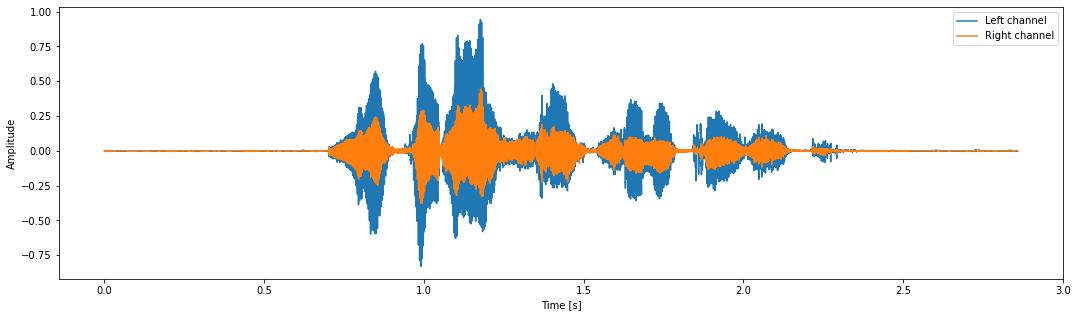

In [8]:
# Displaying a random sample
signal = audio_files['dis-f1-b1']

length = signal.shape[1] / sample_rate
time = np.linspace(0., length, signal.shape[1])
plt.figure(figsize=(18,5))
plt.plot(time, signal[0,:], label="Left channel")
plt.plot(time, signal[1,:], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [9]:
# Cropping silence out of the signals
for file, signal in tqdm(audio_files.items()):
    audio_files[file] = librosa.effects.trim(audio_files[file], top_db=10)[0]

  0%|          | 0/588 [00:00<?, ?it/s]

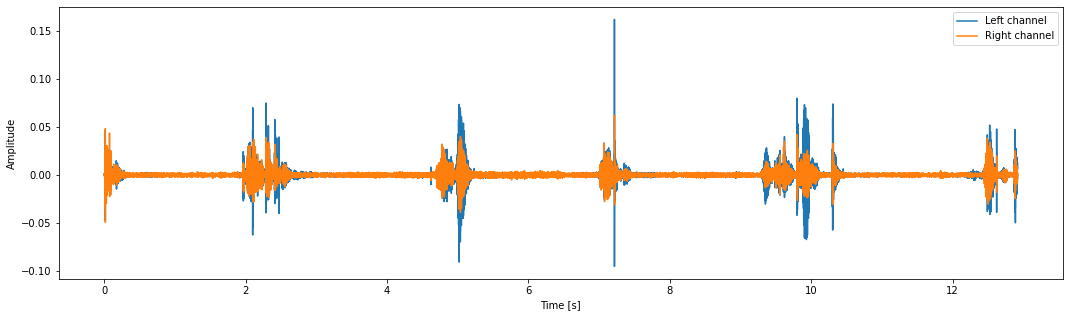

In [10]:
# Displaying a random sample
signal = audio_files['tri-m1-n5']

length = signal.shape[1] / sample_rate
time = np.linspace(0., length, signal.shape[1])
plt.figure(figsize=(18,5))
plt.plot(time, signal[0,:], label="Left channel")
plt.plot(time, signal[1,:], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

### 1.3) LLD dataset

In [11]:
RETRIEVE_FROM_PICKLE = True

if RETRIEVE_FROM_PICKLE:
    with open('data/lld_ds.pkl','rb') as pickle_file:
        lld_ds = pickle.load(pickle_file)
else:
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )
    
    # Loading the signals into llds
    lld_ds = {}
    for file, signal in tqdm(audio_files.items()):
        llds = smile.process_signal(
            signal,
            sample_rate
        )
        lld_ds[file] = llds.to_numpy()
    with open('data/lld_ds.pkl','wb') as pickle_file:
        pickle.dump(lld_ds, pickle_file)

### 1.4) Feature functionals dataset

In [12]:
RETRIEVE_FROM_PICKLE = True

if RETRIEVE_FROM_PICKLE:
    functions_ds = pickle.load(open('data/functions_ds.pkl','rb'))
else:
    lld_vectors = {}
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    functions_ds = {}
    for file, signal in tqdm(audio_files.items()):
        functionals = smile.process_signal(
            signal,
            sample_rate
        )
        functions_ds[file] = functionals.to_numpy()
    with open('data/functions_ds.pkl','wb') as pickle_file:
        pickle.dump(functions_ds,pickle_file)

## 2) LLD datatset categorization

### 2.1) Data preparation

In [13]:
np.mean([descriptors.shape[0] for descriptors in lld_ds.values()])

204.26020408163265

We will crop the audios at twice the average lentgh (ie: 400) to avoid having audio that are much too long compared to the rest.

In [14]:
x_length = len(lld_ds)
max_length = 400
descriptor_count = list(lld_ds.values())[0].shape[1]

x = np.zeros((x_length,max_length,descriptor_count))

for i, descriptor in enumerate(lld_ds.values()):
    x[i,:,:] = np.pad(descriptor[:max_length,:], [(0, (max_length - descriptor.shape[0] if max_length > descriptor.shape[0] else 0)), (0,0)])

In [15]:
# Normalization of x vector
mean = np.mean(x, axis=(0,1))
std = np.std(x, axis=(0,1))

x = ((x - mean)/std)
x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

In [16]:
# Generate y vector from emotion labels and convert to categorical vector
y = files_metadata.join(emotions.set_index('emotion_code'), on='emotion_code')['numerical_code']
y = to_categorical(y)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### 2.2) Feature embedding

#### 2.2.1) LSTM Autoencoder

In [75]:
# Model Layers
inputs = Input(shape=(max_length, descriptor_count))
encoder = LSTM(400)(inputs)

decoder = RepeatVector(max_length)(encoder)
outputs = LSTM(descriptor_count, return_sequences=True)(decoder)

# Model definition and compilation
autoencoder = Model(inputs=inputs, outputs=outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# # Training of the model
# history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=10, verbose=2, validation_data=(x_test, x_test))

# # Display of the training results
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 400, 65)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 400)               745600    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 400, 400)         0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 400, 65)           121160    
                                                                 
Total params: 866,760
Trainable params: 866,760
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_encoder = Model(inputs=inputs, outputs=encoder)
lstm_encoder.save('models/lstm_encoder.h5')

#### 2.2.2) Convolutional Autoencoder

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 65, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 400, 65, 32)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 65, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 65, 64)       8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 65, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 65, 128)       4108

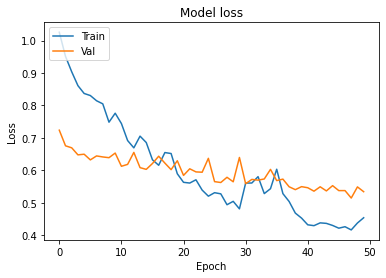

In [20]:
# Model layers
inputs = Input(shape=(max_length, descriptor_count,1))

# Encoder layers
e = Conv2D(32, (4,1), activation='relu', padding='same')(inputs)
e = MaxPooling2D((4,1), padding='same')(e)
e = Conv2D(64, (4,1), activation='relu', padding='same')(e)
e = MaxPooling2D((4,1), padding='same')(e)
e = Conv2D(128, (5,1), activation='relu', padding='same')(e)
e = MaxPooling2D((5,1), padding='same')(e)
e = Conv2D(256, (5,1), activation='relu', padding='same')(e)
e = MaxPooling2D((5,1), padding='same')(e)

encoder = Flatten()(e)

# Decoder layers
d = Reshape((1, 65, 256))(encoder)
d = Conv2DTranspose(128, (5,1), activation='relu', padding='same', strides=(5,1))(d)
d = Conv2DTranspose(64, (5,1), activation='relu', padding='same', strides=(5,1))(d)
d = Conv2DTranspose(32, (4,1), activation='relu', padding='same', strides=(4,1))(d)

# Output layer
outputs = Conv2DTranspose(1, (4,1), activation='relu', padding='same', strides=(4,1))(d)

# Model definition
autoencoder = Model(inputs=inputs, outputs=outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Model training
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=10, verbose=2, validation_data=(x_test, x_test))

# Display of the training results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [21]:
conv_encoder = Model(inputs=inputs, outputs=encoder)
conv_encoder.save('models/conv_encoder.h5')

#### 2.2.3) Deep Autoencoder

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 65, 1)]      0         
                                                                 
 flatten_1 (Flatten)         (None, 26000)             0         
                                                                 
 dense (Dense)               (None, 1000)              26001000  
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                           

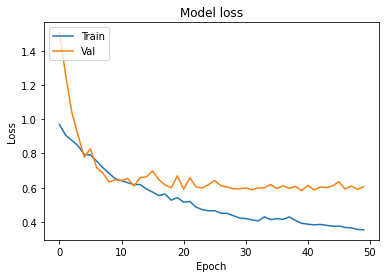

In [22]:
# Model Layers
inputs = Input(shape=(max_length, descriptor_count,1))

# Encoder layers
e = Flatten()(inputs)
# encoder level 1
e = Dense(1000)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(500)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = 200
encoder = Dense(n_bottleneck)(e)

# Decoder Layers
# decoder, level 1
d = Dense(500)(encoder)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(1000)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
d = Dense(max_length*descriptor_count, activation='linear')(d)

# output layer
outputs = Reshape((max_length, descriptor_count, 1))(d)

# Model definition and compilation
autoencoder = Model(inputs=inputs, outputs=outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Model training 
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=10, verbose=2, validation_data=(x_test, x_test))

# Display of the training results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [23]:
deep_encoder = Model(inputs=inputs, outputs=encoder)
deep_encoder.save('models/deep_encoder.h5')

### 2.3) Classification with embedding

In [24]:
encoders = {
    'lstm_encoder': lstm_encoder,
    'conv_encoder': conv_encoder, 
    'deep_encoder': deep_encoder
}
for name, encoder in encoders.items():
    print('')
    print('-----------------------------------------------------------------------------------------------------------')
    print(f'Encoder: {name}')
    print('-----------------------------------------------------------------------------------------------------------')
    
    # embedding data
    x_train_emb = encoder.predict(x_train)
    x_test_emb = encoder.predict(x_test)

    # IO sizes
    input_size = x_train_emb.shape[-1]
    output_size = y_train.shape[-1]

    # Model layers
    inputs = Input(shape=(input_size))
    hidden_l = Dense(512, activation='relu')(inputs)
    hidden_l = Dropout(0.2)(hidden_l)
    hidden_l = Dense(128, activation='relu')(hidden_l)
    outputs = Dense(output_size, activation='softmax')(hidden_l)

    # Model definition and compilation
    deep_classifier = Model(inputs, outputs)
    deep_classifier.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Model training
    batch_size = 5
    epochs = 20
    history = deep_classifier.fit(x_train_emb, y_train, epochs=epochs, validation_split=0.2, batch_size=batch_size)
    
    _, train_acc = deep_classifier.evaluate(x_train_emb, y_train, verbose=1)
    _, test_acc = deep_classifier.evaluate(x_test_emb, y_test, verbose=1)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


-----------------------------------------------------------------------------------------------------------
Encoder: lstm_encoder
-----------------------------------------------------------------------------------------------------------
Epoch 1/20
76/76 [==============================] - 1s 7ms/step - loss: 1.9175 - accuracy: 0.2074 - val_loss: 1.9747 - val_accuracy: 0.1277
Epoch 2/20
76/76 [==============================] - 0s 5ms/step - loss: 1.8116 - accuracy: 0.2580 - val_loss: 1.8913 - val_accuracy: 0.2021
Epoch 3/20
76/76 [==============================] - 0s 5ms/step - loss: 1.7747 - accuracy: 0.2739 - val_loss: 1.9084 - val_accuracy: 0.1702
Epoch 4/20
76/76 [==============================] - 0s 5ms/step - loss: 1.7462 - accuracy: 0.2660 - val_loss: 1.9218 - val_accuracy: 0.2021
Epoch 5/20
76/76 [==============================] - 0s 6ms/step - loss: 1.7280 - accuracy: 0.2686 - val_loss: 1.9793 - val_accuracy: 0.1915
Epoch 6/20
76/76 [==============================] - 0s 6ms/st

### 2.4) Regular Classification

In [87]:
output_size = y_train.shape[-1]

# Model layers
inputs = Input(shape=(max_length, descriptor_count,1))

# Convolution layers to take into account the sequentiallity
hidden_l = Conv2D(16, (4,1), activation='relu', padding='same')(inputs)
hidden_l = MaxPooling2D((4,1), padding='same')(hidden_l)

hidden_l = Conv2D(32, (5,1), activation='relu', padding='same')(hidden_l)
hidden_l = MaxPooling2D((5,1), padding='same')(hidden_l)

hidden_l = Conv2D(64, (5,1), activation='relu', padding='same')(hidden_l)
hidden_l = MaxPooling2D((5,1), padding='same')(hidden_l)

hidden_l = Conv2D(128, (4,1), activation='relu', padding='same')(hidden_l)
hidden_l = MaxPooling2D((4,1), padding='same')(hidden_l)

# Flattening of the still 2D data
hidden_l = Flatten()(hidden_l)

# Dense classifier
hidden_l = Dense(512, activation='relu')(hidden_l)
hidden_l = Dense(128, activation='relu')(hidden_l)
outputs = Dense(output_size, activation='softmax')(hidden_l)

# Model definition and compilation
deep_classifier = Model(inputs, outputs)
deep_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
deep_classifier.summary()

# Model training
history = deep_classifier.fit(x_train, y_train, epochs=20, batch_size=5, validation_split=0.2)

# Display of training history
plot_history(history)

# Model evaluation
_, train_acc = deep_classifier.evaluate(x_train, y_train, verbose=1)
_, test_acc = deep_classifier.evaluate(x_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 400, 65, 1)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 400, 65, 16)       80        
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 100, 65, 16)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 65, 32)       2592      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 20, 65, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 65, 64)        103

ValueError: in user code:

    File "C:\Users\arnau\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\arnau\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\arnau\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\arnau\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\arnau\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\arnau\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_15" is incompatible with the layer: expected shape=(None, 400, 65, 1), found shape=(None, 6373)


In [32]:
y_pred = np.argmax(deep_classifier.predict(x_test), axis=1)
cat_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

,disgust,joy,neutral,fear,anger,surprise,sadness
disgust,0.352941,0.117647,0.235294,0.000000,0.117647,0.117647,0.058824
joy,0.090909,0.181818,0.272727,0.181818,0.181818,0.090909,0.000000
neutral,0.181818,0.090909,0.363636,0.000000,0.363636,0.000000,0.000000
fear,0.153846,0.230769,0.000000,0.538462,0.076923,0.000000,0.000000
anger,0.000000,0.285714,0.000000,0.000000,0.714286,0.000000,0.000000
surprise,0.176471,0.352941,0.058824,0.117647,0.117647,0.176471,0.000000
sadness,0.041667,0.000000,0.458333,0.083333,0.041667,0.041667,0.333333


In [33]:
deep_classifier.save('models/deep_lld_classifier.h5')

## 3) Functionals dataset

### 3.1) Data preparation

In [34]:
count = len(functions_ds)
functionals_count = len(functions_ds['dis-f1-b1'][0])

x = np.zeros((count, functionals_count))

# Generate x vector from functionals data
for i, file in enumerate(functions_ds):
    x[i,:] = functions_ds[file]

In [35]:
# Normalization of x vector
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

x = ((x - mean)/std)
x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

In [36]:
# Generate y vector from emotion labels and convert to categorical vector
y = files_metadata.join(emotions.set_index('emotion_code'), on='emotion_code')['numerical_code']
y = to_categorical(y)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### 3.2) Feature embedding

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 6373)]            0         
                                                                 
 dense_24 (Dense)            (None, 1000)              6374000   
                                                                 
 batch_normalization_5 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1000)              0         
                                                                 
 dense_25 (Dense)            (None, 500)               500500    
                                                                 
 batch_normalization_6 (Batc  (None, 500)              2000      
 hNormalization)                                          

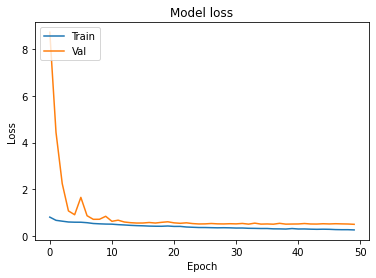

In [39]:
# AUTO-ENCODER
input_size = x_train.shape[-1]

# Model Layers
inputs = Input(shape=(input_size))
# encoder level 1
e = Dense(1000)(inputs)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(500)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = 100
encoder = Dense(n_bottleneck)(e)

# define decoder, level 1
d = Dense(500)(encoder)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(1000)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
outputs = Dense(input_size, activation='linear')(d)

# Model defininition and compilation
autoencoder = Model(inputs=inputs, outputs=outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Model training
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=20, verbose=2, validation_data=(x_test, x_test))

# Display of the training results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [40]:
func_encoder = Model(inputs=inputs, outputs=encoder)
func_encoder.save('models/func_encoder.h5')

In [41]:
# embedding data
x_train_emb = func_encoder.predict(x_train)
x_test_emb = func_encoder.predict(x_test)

### 3.3) Classification

#### 3.3.1) DNN classifier

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_30 (Dense)            (None, 512)               51712     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               65664     
                                                                 
 dense_32 (Dense)            (None, 7)                 903       
                                                                 
Total params: 118,279
Trainable params: 118,279
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
76/76 [==============================] - 

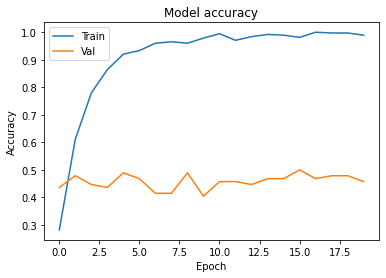

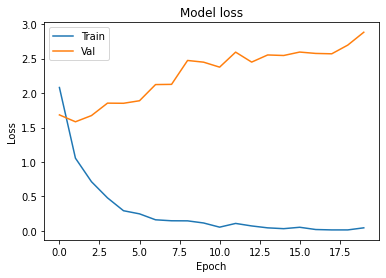

4/4 [==============================] - 0s 4ms/step - loss: 2.6955 - accuracy: 0.4068
Train: 0.868, Test: 0.407


,disgust,joy,neutral,fear,anger,surprise,sadness
disgust,0.473684,0.157895,0.157895,0.000000,0.000000,0.105263,0.105263
joy,0.000000,0.357143,0.285714,0.071429,0.214286,0.071429,0.000000
neutral,0.200000,0.000000,0.466667,0.000000,0.066667,0.000000,0.266667
fear,0.238095,0.333333,0.047619,0.238095,0.000000,0.095238,0.047619
anger,0.000000,0.266667,0.000000,0.000000,0.733333,0.000000,0.000000
surprise,0.157895,0.263158,0.052632,0.368421,0.000000,0.157895,0.000000
sadness,0.133333,0.133333,0.200000,0.000000,0.000000,0.000000,0.533333


In [42]:
input_size = x_train_emb.shape[-1]
output_size = y_train.shape[-1]

# Model layers
inputs = Input(shape=(input_size))
hidden_l = Dense(512, activation='relu')(inputs)
hidden_l = Dropout(0.2)(hidden_l)
hidden_l = Dense(128, activation='relu')(hidden_l)
outputs = Dense(output_size, activation='softmax')(hidden_l)

# Model definition and compilation
deep_classifier = Model(inputs, outputs)
deep_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
deep_classifier.summary()

# Model training
history = deep_classifier.fit(x_train_emb, y_train, epochs=20, batch_size=5, validation_split=0.2)

# Display of training history
plot_history(history)

# Model evaluation
_, train_acc = deep_classifier.evaluate(x_train_emb, y_train, verbose=1)
_, test_acc = deep_classifier.evaluate(x_test_emb, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Print Categorical confusion matrix
y_pred = np.argmax(deep_classifier.predict(x_test_emb), axis=1)
cat_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

#### 3.3.2) Logisitc regression classifier

In [43]:
# Model definition
model = LogisticRegression(max_iter=1000)

# Model fitting
model.fit(x_train_emb, np.argmax(y_train, axis=1))

# Model evaluation
print(f'Model score: {model.score(x_test_emb, np.argmax(y_test, axis=1)):.3f}')

# Print Categorical confusion matrix
y_pred = model.predict(x_test_emb)
cat_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

Model score: 0.424


,disgust,joy,neutral,fear,anger,surprise,sadness
disgust,0.526316,0.105263,0.157895,0.000000,0.000000,0.105263,0.105263
joy,0.000000,0.285714,0.214286,0.000000,0.285714,0.214286,0.000000
neutral,0.200000,0.000000,0.533333,0.066667,0.066667,0.066667,0.066667
fear,0.095238,0.238095,0.047619,0.285714,0.000000,0.333333,0.000000
anger,0.066667,0.266667,0.000000,0.000000,0.666667,0.000000,0.000000
surprise,0.210526,0.052632,0.105263,0.263158,0.052632,0.315789,0.000000
sadness,0.066667,0.000000,0.333333,0.133333,0.000000,0.066667,0.400000


### 3.3.3) Random forest classifier

In [44]:
# Model definition
model = RandomForestClassifier()

# Model fitting
model.fit(x_train_emb, np.argmax(y_train, axis=1))

# Model evaluation
print(f'Model score: {model.score(x_test_emb, np.argmax(y_test, axis=1)):.3f}')

# Print Categorical confusion matrix
y_pred = model.predict(x_test_emb)
cat_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

Model score: 0.314


,disgust,joy,neutral,fear,anger,surprise,sadness
disgust,0.368421,0.157895,0.105263,0.105263,0.052632,0.052632,0.157895
joy,0.000000,0.142857,0.214286,0.000000,0.428571,0.142857,0.071429
neutral,0.066667,0.066667,0.533333,0.066667,0.000000,0.066667,0.200000
fear,0.047619,0.333333,0.142857,0.000000,0.000000,0.333333,0.142857
anger,0.000000,0.333333,0.066667,0.066667,0.533333,0.000000,0.000000
surprise,0.052632,0.210526,0.105263,0.263158,0.052632,0.210526,0.105263
sadness,0.066667,0.000000,0.200000,0.066667,0.000000,0.133333,0.533333


### 3.3.4) SGD classifier

In [45]:
# Model definition
model = SGDClassifier()

# Model fitting
model.fit(x_train_emb, np.argmax(y_train, axis=1))

# Model evaluation
print(f'Model score: {model.score(x_test_emb, np.argmax(y_test, axis=1)):.3f}')

# Print Categorical confusion matrix
y_pred = model.predict(x_test_emb)
cat_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

Model score: 0.441


,disgust,joy,neutral,fear,anger,surprise,sadness
disgust,0.315789,0.210526,0.000000,0.000000,0.052632,0.263158,0.157895
joy,0.000000,0.357143,0.071429,0.000000,0.142857,0.428571,0.000000
neutral,0.066667,0.000000,0.600000,0.066667,0.000000,0.266667,0.000000
fear,0.142857,0.095238,0.095238,0.285714,0.000000,0.333333,0.047619
anger,0.066667,0.266667,0.000000,0.000000,0.466667,0.200000,0.000000
surprise,0.105263,0.105263,0.000000,0.157895,0.000000,0.631579,0.000000
sadness,0.133333,0.000000,0.133333,0.000000,0.000000,0.266667,0.466667


## 4) Final product

In [65]:
def predict_emotions(file):
    # Retrieving of the signal from the file given
    signal, sample_rate = audiofile.read(file)
    
    # Extraction of the lld features
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )
    
    llds = smile.process_signal(signal, sample_rate).to_numpy()
    
    # Data preparation
    max_length = 400
    descriptors_count = llds.shape[1]
    # Crop to "max_length" or fill up to max_length with zeros
    x = np.pad(llds[:max_length,:], [(0, (max_length - llds.shape[0] if max_length > llds.shape[0] else 0)), (0,0)])
    
    # Data normalization
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)

    x = ((x - mean)/std)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Retrieve encoder model
    model = models.load_model('models/deep_lld_classifier.h5')
    
    # Predict emotion
    pred = model.predict(x.reshape((1,400,65)))[0]
    
    # Print result
    em_order = np.argsort(pred)
    em_1 = em_order[-1]
    em_1_prec = pred[em_1]
    em_2 = em_order[-2]
    em_2_prec = pred[em_2]
    
    print(f'The emotion of this audio is detected as being: 1. {emotions.loc[em_1].en_name} ({em_1_prec*100:.1f}%),  1. {emotions.loc[em_2].en_name} ({em_2_prec*100:.1f}%)')

In [74]:
predict_emotions('data/EMOVO/f3/rab-f3-b2.wav')

The emotion of this audio is detected as being: 1. anger (84.3%),  1. joy (8.6%)


## 5) Sources

- Dataset downloaded from: http://voice.fub.it/activities/corpora/emovo/index.html
- Dataset paper: http://www.lrec-conf.org/proceedings/lrec2014/pdf/591_Paper.pdf


- COMPARE low level descriptors: https://www.researchgate.net/publication/259889707_The_INTERSPEECH_2014_computational_paralinguistics_challenge_Cognitive_physical_load/figures?lo=1
- Feature embedding with autoencoder: https://machinelearningmastery.com/autoencoder-for-classification/


- IEMOCAP exploration: https://github.com/Exploration-Lab/COGMEN
- IEMOCAP emotion recognition: https://github.com/Aditya3107/IEMOCAP_EMOTION_Recognition